# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem (NEP) - **MESH SIZE ANALYSIS**

#### Importing library

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

In [3]:
# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

#### Initialize

In [4]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [5]:
np.random.seed(23)

### Nonlinear Elliptic Problem definition
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu) \text{  (NEP)}
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

## Exact solution definition
As a preliminar step, to evaluate the error of the solution computed using Newton method, we will apply the Newton algorithm to solve a PDE of which we know the exact solution. In particular, we'll consider an exact solution $\tilde{u}$ and compute the forcing term $\tilde{g}$ st it is solution to our differential problem. Then, we will solve the PDE using the Netwon schema and evaluate the error of the approximation of $\tilde{u}$ wrt the exact solution.

Take the exact solution 
$$\tilde{u}(x,y;\mu)= \mu_0xy(1-x)(1-y)$$
and compute the forcing term $\tilde{g}(x,y;\mu)$ st $$-\Delta \tilde{u}(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \tilde{g}(x, y;\mu)$$
To do so, compute the laplacian of $\tilde{u}$: $$\Delta \tilde{u}(\mu) = -2 \mu_0 (y(1-y) + x(1-x))$$ and substitute $\tilde{u}$ in the non linear term of the PDE : $$\frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1 ) $$

Then, the forcing term for this problem is $$\tilde{g}(x,y;\mu) = 2 \mu_0 (y(1-y) + x(1-x)) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \mu_0xy(1-x)(1-y)} - 1) $$

Now consider the parametric PDE $-\Delta \tilde{u}(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}(\mu)} - 1) = \tilde{g}(x, y;\mu)$.

### Passage from Strong Formulation to Weak Formulation and Newton Scheme for the EXACT SOLUTION
**Mathematical note:** the weak formulation is derived by multiplication by a test function $v$ and integration by parts. We assume that $u \in H_0^1(\Omega)$, i.e. functions with weak square-integrable derivatives and null on the edge. This allows us to look for solutions in function spaces that are more regular than the strong formulation.

**Weak Formulation.**
Find $\tilde{u} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX = 0$$
Hence, the weak formulation is:
$$\int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX = \int_{\Omega} \tilde{g} v \, dX$$
where on the left can be found the unkown $\tilde{u}$ and on the right the forcing term.

**Definition of the Nonlinear Operator.**
Define the operator $F: H_0^1(\Omega) \to (H_0^1(\Omega))'$ such that for $u \in H_0^1(\Omega)$ and $v \in H_0^1(\Omega)$:
$$F(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX$$
Solving the PDE means finding $\tilde{u}$ st $F(\tilde{u})[v]=0$ for every $v$, which we solve using the Newton schema.

**Fréchet Derivative of $F(u)$.**
Calculate the Fréchet derivative $DF(u)[\delta u] \in (H_0^1(\Omega))'$ for an increment $\delta u \in H_0^1(\Omega)$. For every $v \in H_0^1(\Omega)$:
$$DF(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F(u + \epsilon \delta u)[v] - F(u)[v]}{\epsilon}$$
Consider each term of $F(u)[v]$ separately.

1.  **Linear Term.** $F_1(\tilde{u})[v] = \int_{\Omega} \nabla \tilde{u} \cdot \nabla v \, dX$.
    $$DF_1(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \nabla \delta \tilde{u} \cdot \nabla v \, dX$$

2.  **Nonlinear Term.** $F_2(\tilde{u})[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} -1) v \, dX$.
    The Fréchet derivative of $F_2(u)$ is given by:
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \lim_{\epsilon \to 0} \frac{F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v]}{\epsilon}$$
    **Expansion of $F_2(\tilde{u} + \epsilon \delta \tilde{u})[v]$.**
    $\begin{align*}
    F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 (\tilde{u} + \epsilon \delta \tilde{u})} - 1) v \, dX\\
    &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta \tilde{u}} - 1) v \, dX
    \end{align*}$
    **Then**
    $$
    F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta u} - 1) v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} - 1) v \, dX
    $$
    $$= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}} e^{\mu_1 \epsilon \delta \tilde{u}} - e^{\mu_1 \tilde{u}}) v \, dX = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}} (e^{\mu_1 \epsilon \delta \tilde{u}} - 1) v \, dX
    $$

    **Division by $\epsilon$.**
    $$\frac{F_2(\tilde{u} + \epsilon \delta \tilde{u})[v] - F_2(\tilde{u})[v]}{\epsilon} = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}} \frac{(e^{\mu_1 \epsilon \delta \tilde{u}} - 1)}{\epsilon} v \, dX$$
    **Notable Limit.**
    We use the notable limit $\lim_{t \to 0} \frac{e^{at} - 1}{t} = a$. In our case, $t = \epsilon$ and $a = \mu_1 \delta u(X)$. Thus:
    $$\lim_{\epsilon \to 0} \frac{e^{\mu_1 \epsilon \delta \tilde{u}(X)} - 1}{\epsilon} = \mu_1 \delta \tilde{u}(X)$$
    **Passing to the Limit.**
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \lim_{\epsilon \to 0} \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}(X)} \frac{(e^{\mu_1 \epsilon \delta \tilde{u}(X)} - 1)}{\epsilon} v(X) \, dX$$
    Assuming we can interchange the limit and the integral (which requires appropriate regularity conditions), we obtain:
    $$DF_2(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 \tilde{u}(X)} (\mu_1 \delta \tilde{u}(X)) v(X) \, dX = \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}(X)} \delta \tilde{u}(X) v(X) \, dX$$

3.  **Term Independent of $\tilde{u}$.** $F_3(\tilde{u})[v] = - \int_{\Omega} \tilde{g} v \, dX$.
    $$DF_3(\tilde{u})[\delta \tilde{u}][v] = 0$$

**The Jacobian Operator (Fréchet Derivative) of $F(u)$ is therefore**
$$DF(\tilde{u})[\delta \tilde{u}][v] = \int_{\Omega} \nabla \delta \tilde{u} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}} \delta \tilde{u} v \, dX$$

**Newton Scheme.**
The Newton scheme to find the root of $F(\tilde{u}) = 0$ is given by:
$$DF(\tilde{u}_k)[\delta \tilde{u}] = -F(\tilde{u}_k)$$
where $\tilde{u}_k$ is the approximation at the $k$-th iteration and $\delta \tilde{u}_k = \tilde{u}_{k+1} - \tilde{u}_k$ is the increment to be found. In variational form, this is written:

Find $\delta \tilde{u}_k \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\left( \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX \right) * \delta \tilde{u} = - \left( \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX \right)$$
**Rewriting the equation for the next iteration $\tilde{u}_{k+1} = \tilde{u}_k + \delta \tilde{u}_k$.**
Find $\tilde{u}_{k+1} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$
\int_{\Omega} \nabla (\tilde{u}_{k+1} - \tilde{u}_k) \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} (\tilde{u}_{k+1} - \tilde{u}_k) v \, dX = - \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Rearranging the terms, we obtain the variational form of the linear system to be solved at each Newton iteration to find $\tilde{u}_{k+1}$:**
$$\int_{\Omega} \nabla \tilde{u}_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_{k+1} v \, dX = \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_k v \, dX - \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Which simplifies to**

$$\int_{\Omega} \nabla \tilde{u}_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_{k+1} v \, dX = \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \tilde{u}_k v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX + \int_{\Omega} \tilde{g} v \, dX$$

**Analisys of all the terms of the system**

$$\left( \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX \right) * \delta \tilde{u} = - \left( \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX - \int_{\Omega} \tilde{g} v \, dX \right)$$

1. Left-hand side (Jacobian applied to Newton increment):
       
    **Diffusion term**:  $
      \int_{\Omega} \nabla \delta \tilde{u}_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term** (derivative of the exponential term):  $
      \int_{\Omega} \mu_0 e^{\mu_1 \tilde{u}_k} \delta \tilde{u}_k v \, dX
      $

2. Right-hand side (Nonlinear residual at step \( u_k \)):

    **Diffusion term**:  $
      \int_{\Omega} \nabla \tilde{u}_k \cdot \nabla v \, dX
      $
      
    **Nonlinear reaction term**:  $
      \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 \tilde{u}_k} -1) v \, dX
      $
      
    **Source term**:  $
      \int_{\Omega} \tilde{g} v \, dX
      $

#### Error computation for the exact solution
Since we know the exact solution, when solving the high fidelity problem using Newton schema, we can compute exactly the error of approximation of $\tilde{u}$ with $\tilde{u}_k$:
$$\frac{||\tilde{u}_k - \tilde{u}||_{L^2}}{||\tilde{u}||_{L^2}}$$

#### Definition of the different terms for the exact solution
NB: We'll use the same terms also when solving the real problem (of unknown solution), except for the forcing term $g$.

These functions (```Elliptic_a```, ```Elliptic_c```) take a number of numPoints as input, construct an array full of 1s with numPoints elements. They then return a memory pointer (ctypes.data) - typical when you need to interface with C code, or with libraries that expect ‘raw’ arrays.

In [6]:
# Points on which we want to integrate - We leave the structure of Lab12

# Points for the diffusion term
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F') # Fortran order of memorization of the matrix: column by column
	return values_a.ctypes.data

# Points for the reaction term
def Elliptic_c(numPoints, points):
	values_c = np.ones(numPoints, order='F') 
	return values_c.ctypes.data    

# QUESTION? We need np.ones((2, numPoints), order='F')?
# ANSWER! No, only the advection term has a vector field as its coefficient --> hence, we need np.ones((2, numPoints), order='F')
#         only if we have advection term (that we do not have)

In [7]:
# NOTE: x=x_0, y=x_1

# Non linear reaction term
# numPoints := quadrature points
def Elliptic_non_linear_c(numPoints, points, u, u_x, u_y):
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in the quadrature points numPoints
	values_nl_c = vec_u
	return values_nl_c.ctypes.data

This function (```Elliptic_non_linear_der_f```) provides the local values of the gradient of u for an integral related to the diffusion term on the right-side of the equation.
$$\int_{\Omega} \nabla u_k \cdot \nabla v \, dX$$

The function takes the ```u_x``` and ```u_y``` derivatives, organises them into an array ```[ [u_x], [u_y] ]``` in column order, and returns the memory pointer of that array, to be used in an external computational context (probably in a numerical FEM-type method).

In [8]:
def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
    # Converts u_x and u_y pointers or arrays to NumPy arrays
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
	values_nl_d_f = np.zeros((2, numPoints), order='F')

    # Inserts the partial derivatives of u into the new array values_nl_d_f
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
    
	return values_nl_d_f.ctypes.data

The function `Elliptic_non_linear_f` evaluates the term:

$$
f(u) = \frac{\mu_0}{\mu_1}(e^{\mu_1 u} - 1)
$$

...in `numPoints` points, and returns the values as C-compatible arrays, to be integrated into the second member (right) of the weak form of a nonlinear PDE problem.


This function is therefore relative to the nonlinear reaction term:
$$\int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX
$$

In [9]:
# Nonlinear reaction term
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
    vec_u = gedim.make_nd_array(u, numPoints, np.double)
    vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
    vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
    values_nl_f = (mu_0/mu_1) * (np.exp(mu_1*vec_u)-1) # Computation of f
    
    return values_nl_f.ctypes.data

Set the exact solution, it is a regular solution defined in the omega domain,
$$
u = \mu_0 xy(1-x)(1-y)
$$

In [10]:
def Elliptic_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

    # Definition of u
	values_ex = mu_0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
    
	return values_ex.ctypes.data

In [11]:
def Elliptic_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0: # wrt x
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) # 16⋅(1−2x)⋅y⋅(1−y)
	elif direction == 1: # wrt y
		values_ex_d = mu_0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]) # 16⋅(1−2y)⋅x⋅(1−x)
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

In [12]:
# Refer to the g that we computed wrt the exact solution u

# Forcing term for evaluating the error
def Elliptic_exactSolution_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    
    # Definition of u
    # values_ex = 2*mu_0*(y*(1-y)+x*(1-x)) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*x*y*(1-x)(1-y)) -1)
    values_ex = 2*mu_0*(matPoints[1,:]*(1-matPoints[1,:])+matPoints[0,:]*(1-matPoints[0,:])) + (mu_0/mu_1)*(np.exp(mu_0*mu_1*matPoints[0,:]*matPoints[1,:]*(1-matPoints[0,:])*(1-matPoints[1,:])) -1)
    
    return values_ex.ctypes.data

These **`Ones`**, **`Zeros`**, and their **`Derivative`** versions serve a very practical and common purpose in numerical methods (especially FEM/FDM/FVM): **provide constant functions** or **derivative constants** to be used as:

* **known terms** (constant sources)
**boundary conditions** (e.g. Dirichlet or Neumann constants)
* **test or debug checks**
* **auxiliary functions** to test code behaviour


| Function | Purpose |
| ----------------- | ------------------------------------------- |
| `Ones` | Constant value 1 (e.g. $f(x)=1$) |
| `OnesDerivative` | Dummy ‘constant’ derivative (for testing) |
| `Zeros` | Constant value 0 (e.g. $u=0$, $f=0$) |
| `ZerosDerivative` | Null Derivative (e.g. homogeneous Neumann, test) |

In [13]:
def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

#### Define the High Fidelity Simulation Parameters
For a parametric problem we need not only the order of the discretization, but also the parametric space definition.

In [14]:
order = 1 # Start from 1, at the END we will decide if we have to improve the order
P = [0.1, 1.] # Parametric space

| Error | Meaning | When to use it |
| -------------------------- | ------------------------------------------------------------------------------------ | --------------------------------------------------------------------------- |
| `rel_error_L2` | Relative error in norm $L^2$: average accuracy of the solution | When you are interested in the **average value solution**, e.g. states |
| `rel_error_H1` | Relative error in norm $H^1$: accuracy including derivatives | When you are interested in **energy** or **derivative** (e.g. gradients, flows) |
| `residual_norm / u_normL2` | Relative residual in $L^2$: how well the solution satisfies the system (not accuracy) | Serves as a **criterion of convergence of Newton's method** |

# PRELIMINARY ANALISYS ON THE MESH SIZE VALUE
## Mean error decrease with decreasing mesh size
We evaluate how a decrement in the mesh size leads to a smaller error: in particular, fixing a mesh size, for a sample of 100 parameters $\mu=(\mu_0, \mu_1) \in [0.1,1]^2$, we compute the Newton approximation of the solution (for the exact solution problem) and we evaluate its error wrt the known exact solution. We then average the errors over the 100 parameter samples for that mesh size. We repeat this operation for decreasing values of the mesh size (starting from 0.1 and halfing it at every iteration), until the order of $10^{-4}$, and finally we plot the resulting mean errors of the Newton algorithm wrt the mesh size values.

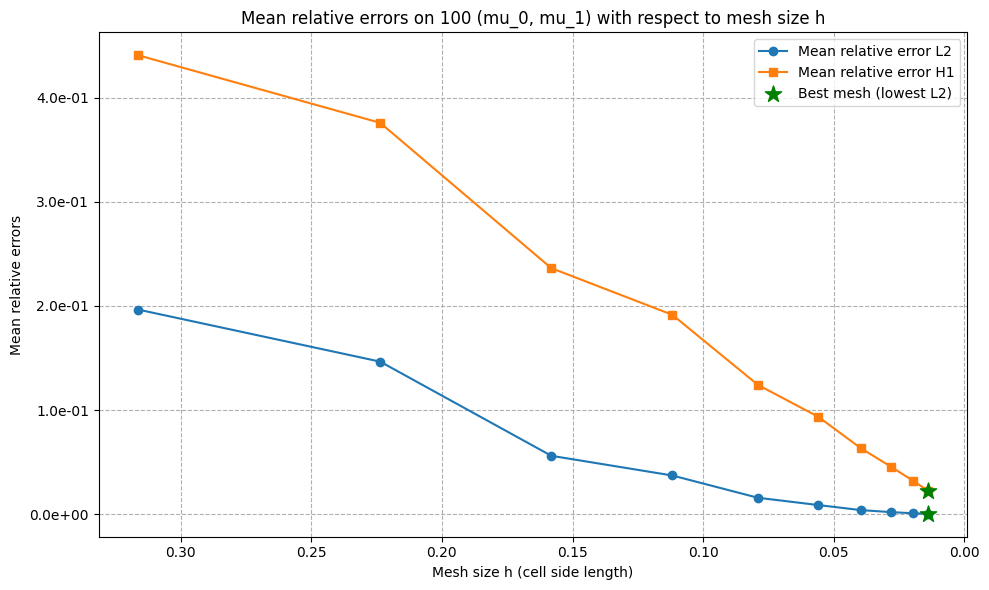

No mesh satisfies L2 ≤ 1e-2 and H1 < 1e-2.
Best mesh with lowest L2 error (or fallback): h = 0.01398 (L2 = 5.24e-04, H1 = 2.27e-02)


In [15]:
# Costanti
num_samples = 100
initial_mesh_size = 0.1
min_mesh_size = 1e-4
max_iterations = 100
newton_tol = 1e-8

# Dizionari per accumulare errori
error_L2_sum = {}
error_H1_sum = {}
error_L2_dict = {}
error_H1_dict = {}

# Lista delle mesh size (come area delle celle)
mesh_sizes_list = []
ms = initial_mesh_size
while ms > min_mesh_size:
    mesh_sizes_list.append(ms)
    error_L2_sum[ms] = 0.0
    error_H1_sum[ms] = 0.0
    ms /= 2

# Campioni (mu_0, mu_1)
mu_0_sample = np.random.uniform(0.1, 1, num_samples)
mu_1_sample = np.random.uniform(0.1, 1, num_samples)

# Loop su tutti i campioni
for mu_0, mu_1 in zip(mu_0_sample, mu_1_sample):
    
    for mesh_size in mesh_sizes_list:
        
        du_norm = 1.0
        u_k_norm = 1.0
        num_iteration = 1

        # Costruzione dominio e discretizzazione
        domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
        [meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
        discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
        [problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
        u_strong = np.zeros(problemData['NumberStrongs'], order='F')
        u_k = np.zeros(problemData['NumberDOFs'], order='F') 
        zero = np.zeros(problemData['NumberDOFs'], order='F')
        du = zero
        u_k = zero

        # Newton loop
        while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 
            [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
            [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
            forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
            forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
            forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)

            du = gedim.LUSolver(stiffness + reaction, forcingTerm_g - forcingTerm_v - forcingTerm_der_v, lib)
            u_k = u_k + du

            du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
            u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
            num_iteration += 1

        exact_error_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib)
        u_exact_norm_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib)
        error_L2_dict[mesh_size] = exact_error_L2 / u_exact_norm_L2
        error_L2_sum[mesh_size] += exact_error_L2 / u_exact_norm_L2

        exact_error_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib)
        u_exact_norm_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib)
        error_H1_dict[mesh_size] = exact_error_H1 / u_exact_norm_H1
        error_H1_sum[mesh_size] += exact_error_H1 / u_exact_norm_H1

# Calcolo errori medi
error_L2_avg = [error_L2_sum[h] / num_samples for h in mesh_sizes_list]
error_H1_avg = [error_H1_sum[h] / num_samples for h in mesh_sizes_list]
mesh_l_sizes = [np.sqrt(h) for h in mesh_sizes_list]  # lato = sqrt(area)

# Ricerca prima mesh che soddisfa condizioni di errore
first_mesh_satisfying_condition = None
for h, l2, h1 in zip(mesh_sizes_list, error_L2_avg, error_H1_avg):
    if l2 <= 1e-2 and h1 < 1e-2:
        first_mesh_satisfying_condition = h
        break

# Mesh con minimo errore L2
min_L2 = min(error_L2_avg)
best_mesh = mesh_sizes_list[error_L2_avg.index(min_L2)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mesh_l_sizes, error_L2_avg, marker='o', label='Mean relative error L2')
plt.plot(mesh_l_sizes, error_H1_avg, marker='s', label='Mean relative error H1')

if first_mesh_satisfying_condition:
    idx = mesh_sizes_list.index(first_mesh_satisfying_condition)
    plt.scatter(mesh_l_sizes[idx], error_L2_avg[idx], color='red', label='First mesh with L2≤1e-2 and H1<1e-2', zorder=5)
    plt.scatter(mesh_l_sizes[idx], error_H1_avg[idx], color='red', zorder=5)

if best_mesh:
    idx = mesh_sizes_list.index(best_mesh)
    plt.scatter(mesh_l_sizes[idx], error_L2_avg[idx], color='green', marker='*', s=150, label='Best mesh (lowest L2)', zorder=5)
    plt.scatter(mesh_l_sizes[idx], error_H1_avg[idx], color='green', marker='*', s=150, zorder=5)

plt.gca().invert_xaxis()
plt.xlabel('Mesh size h (cell side length)')
plt.ylabel('Mean relative errors')
plt.title('Mean relative errors on 100 (mu_0, mu_1) with respect to mesh size h')
plt.legend()
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
plt.grid(True, linestyle="--")
plt.tight_layout()
plt.savefig("mean_relative_errors_plot.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Output finale
if first_mesh_satisfying_condition is not None:
    idx = mesh_sizes_list.index(first_mesh_satisfying_condition)
    print(f"First mesh with L2 ≤ 1e-2 and H1 < 1e-2: h = {np.sqrt(first_mesh_satisfying_condition):.5f} "
          f"(L2 = {error_L2_avg[idx]:.2e}, H1 = {error_H1_avg[idx]:.2e})")
else:
    print("No mesh satisfies L2 ≤ 1e-2 and H1 < 1e-2.")

if best_mesh is not None:
    idx = mesh_sizes_list.index(best_mesh)
    print(f"Best mesh with lowest L2 error (or fallback): h = {np.sqrt(best_mesh):.5f} "
          f"(L2 = {error_L2_avg[idx]:.2e}, H1 = {error_H1_avg[idx]:.2e})")


**Results**
We find the two most suitable mesh sizes to be the greates and smallest ones providing an error of at least $10^{-3}$
1) $0.00312$ higher error but faster computation (less points to evaluate in the next steps)
2) $0.00019$ smaller error but more computationally demanding (less points to evaluate in the next steps)

## Check of theoretical results 
From the theory we know that the approximation error should decrease exponentially with decreasing mesh size. In particular, denoting $h$ the mesh size (ie the edge of the mesh polygon - triangle for us) and $s$ the order of the mesh, for the $L^2$ and $H^1$ norms we know :
$$Error_{L^2}(h) = Error_{L^2}(h_0)(\frac{h}{h_0})^{s+1} $$
$$Error_{H^1}(h) = Error_{H^1}(h_0)(\frac{h}{h_0})^{s} $$

where $h_0$ is the starting mesh size and $Error_{L^2}(h) = \frac{ ||\tilde{u}_k - \tilde{u}||_{L^2} }{ || \tilde{u}||_{L^2} }$, ie the relative error of the approximation computed with mesh size h (at convergence of the method) wrt the exact solution. Similarly, $Error_{H^1}(h) =  \frac{ ||\tilde{u}_k - \tilde{u}||_{H^1} }{ || \tilde{u}||_{H^1} } $

We now check if the expected behavior is also observed experimentally in order to assess the quality of the method implementation.

NB: We plot the log of the error and expect to have a linear decay with decreasing mesh size

Global slope L2 (fit): 1.95
Global slope H1 (fit): 0.97
Local slope L2 (last two points): 0.85
Local slope H1 (last two points): 0.46


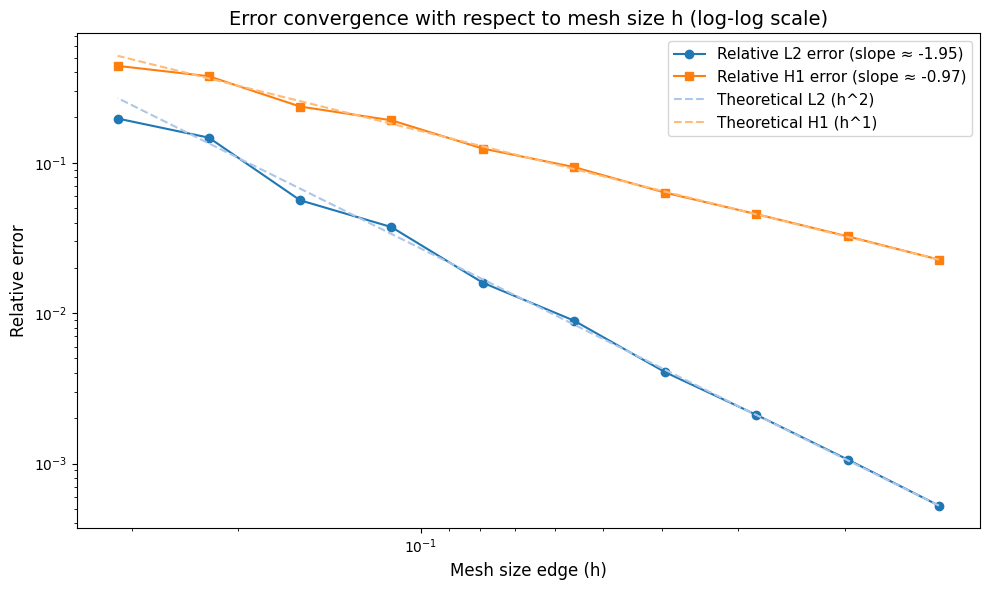

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Convert mesh sizes (area) to h = sqrt(area)
mesh_sizes_area = sorted(error_L2_dict.keys())
mesh_sizes_h = [np.sqrt(h) for h in mesh_sizes_area]

# Extract corresponding errors
error_L2 = [error_L2_dict[h] for h in mesh_sizes_area]
error_H1 = [error_H1_dict[h] for h in mesh_sizes_area]

# FEM order
s = order

# Reference point for theoretical curves
h0 = mesh_sizes_h[0]
e_L2_0 = error_L2[0]
e_H1_0 = error_H1[0]

# Theoretical curves
theoretical_L2 = [e_L2_0 * (h / h0)**(s+1) for h in mesh_sizes_h]
theoretical_H1 = [e_H1_0 * (h / h0)**(s)   for h in mesh_sizes_h]

# Compute slopes global and local
log_h = np.log(mesh_sizes_h)
log_L2 = np.log(error_L2)
log_H1 = np.log(error_H1)

order_L2_obs, _ = -np.polyfit(log_h, log_L2, 1)
order_H1_obs, _ = -np.polyfit(log_h, log_H1, 1)

def compute_slope(errors, hs):
    log_e = np.log(errors[-2:])
    log_h = np.log(hs[-2:])
    return (log_e[1] - log_e[0]) / (log_h[1] - log_h[0])

slope_L2 = compute_slope(error_L2, mesh_sizes_h)
slope_H1 = compute_slope(error_H1, mesh_sizes_h)

print(f"Global slope L2 (fit): {abs(order_L2_obs):.2f}")
print(f"Global slope H1 (fit): {abs(order_H1_obs):.2f}")
print(f"Local slope L2 (last two points): {abs(slope_L2):.2f}")
print(f"Local slope H1 (last two points): {abs(slope_H1):.2f}")

# Colors
color_L2 = '#1f77b4'
color_H1 = '#ff7f0e'
color_L2_theory = '#aec7e8'
color_H1_theory = '#ffbb78'

# Plot
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.loglog(mesh_sizes_h, error_L2, 'o-', color=color_L2, label=f'Relative L2 error (slope ≈ {(order_L2_obs):.2f})', markersize=6)
ax.loglog(mesh_sizes_h, error_H1, 's-', color=color_H1, label=f'Relative H1 error (slope ≈ {(order_H1_obs):.2f})', markersize=6)
ax.loglog(mesh_sizes_h, theoretical_L2, '--', color=color_L2_theory, label=f'Theoretical L2 (h^{s+1})', linewidth=1.5)
ax.loglog(mesh_sizes_h, theoretical_H1, '--', color=color_H1_theory, label=f'Theoretical H1 (h^{s})', linewidth=1.5)

ax.set_xlabel('Mesh size edge (h)', fontsize=12)
ax.set_ylabel('Relative error', fontsize=12)
ax.set_title('Error convergence with respect to mesh size h (log-log scale)', fontsize=14)

ax.invert_xaxis()
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig("convergence_plot_h.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


**Results**  : It works as expected.

**Answer**. Yes, it works as expected, if we consider the edge of the mesh and not the area (hence computing the np.sqrt(mesh_size)) we obtain the right and expected value around
Observed order (L2) = 2
Observed order (H1) = 1

## Tradeoff between velocity and accuracy for mesh sizes : error of approximation vs run time
Based on the previous results, we will now evaluate the trade-off between calculation time and error for all Newton iterations, focusing on two mesh sizes: **0.003** and **0.0004**. The aim is to determine whether the increase in calculation time is justified by the change in accuracy obtained.

### mesh_size = 0.00312

In [32]:
# ERROR COMPUTATION USING EXACT SOLUTION 
# OPTION 1 - mesh_size = 
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

newton_tol = 1e-8
mesh_size = 0.00312

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
zero = np.zeros(problemData['NumberDOFs'], order='F') # Null function

max_iterations = 100
mean_time_000312 = 0
rel_error_L2_mean = 0
rel_error_H1_mean = 0

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):

    start_time = time.time()

    u_k = zero
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

        # Compute the errors
        exact_error_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib) # ||u_k - u_exact|| l^2-norm 
        u_exact_norm_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib) # ||u_exact|| l^2-norm 
        rel_error_L2 = exact_error_L2 / u_exact_norm_L2 # Relative error ||u_k - u_exact|| / ||u_exact|| l^2-norm 
        
        
        exact_error_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib) # ||u_k - u_exact|| H^1-norm 
        u_exact_norm_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib) # ||u_exact|| H^1-norm 
        rel_error_H1 = exact_error_H1 / u_exact_norm_H1 # Relative error ||u_k - u_exact|| / ||u_exact|| H^1-norm 
        
        num_iteration = num_iteration + 1

    stop_time = time.time() - start_time
    rel_error_L2_mean += rel_error_L2
    rel_error_H1_mean += rel_error_H1
    mean_time_000312 += stop_time
    
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14} {'rel_err_H1':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f}"
      f"{(num_iteration-1):<6d} {rel_error_L2:<14.2e} {rel_error_H1:<14.2e}")

mean_time_000312 = mean_time_000312/len(sample_mu_0)
rel_error_L2_mean = rel_error_L2_mean/len(sample_mu_0)
rel_error_H1_mean = rel_error_H1_mean/len(sample_mu_0)

print(f"Snapshot computation for one (mu_0, mu_1) is: {mean_time_000312}")    
print(f"The mean relative error L2 for one (mu_0, mu_1) is: {rel_error_L2_mean}")    
print(f"The mean relative error H1 for one (mu_0, mu_1) is: {rel_error_H1_mean}")    

mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.1610     0.8624    5      9.05e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.7492     0.4082    7      8.86e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.2094     0.2304    6      9.04e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.8286     0.2653    7      8.83e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.9413     0.2472    7      8.80e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.4082     0.4829    6      8.97e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.3814     0.6450    6      8.98e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.6403     0.1847    7      8.90e-03       9.37e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.725

In [33]:
# Just to check the final u_k, mu_0, mu_1
last_u_k_exact = u_k

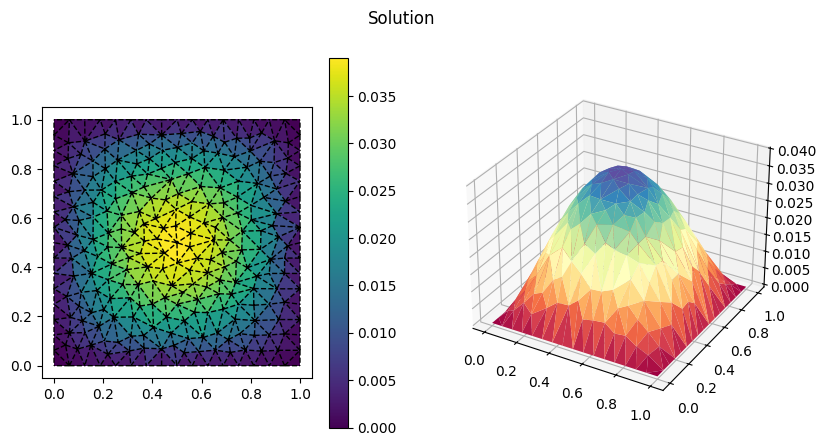

In [34]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

# To export the solution
gedim.ExportSolution(Elliptic_exactSolution, last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

### mesh_size = 0.00019

In [ ]:
# ERROR COMPUTATION USING EXACT SOLUTION 
# OPTION 2 - mesh_size = 0.003
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

mesh_size = 0.00019

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
zero = np.zeros(problemData['NumberDOFs'], order='F') # Null function
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

max_iterations = 100

mean_time_000019 = 0
rel_error_L2_mean_2 = 0
rel_error_H1_mean_2 = 0


for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):

    start_time = time.time()
    
    u_k = zero
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        
        # Linear
        [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # Indipendent from mu_0 & mu_1
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
       
        # 2- Right hand side of the function
        
        # Linear part
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_exactSolution_g, problemData, lib)
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

        # Compute the errors
        exact_error_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, u_k, u_strong, lib) # ||u_k - u_exact|| l^2-norm 
        u_exact_norm_L2 = gedim.ComputeErrorL2(Elliptic_exactSolution, zero, u_strong, lib) # ||u_exact|| l^2-norm 
        rel_error_L2 = exact_error_L2 / u_exact_norm_L2 # Relative error ||u_k - u_exact|| / ||u_exact|| l^2-norm 
        
        exact_error_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, u_k, u_strong, lib) # ||u_k - u_exact|| H^1-norm 
        u_exact_norm_H1 = gedim.ComputeErrorH1(Elliptic_exactDerivativeSolution, zero, u_strong, lib) # ||u_exact|| H^1-norm 
        rel_error_H1 = exact_error_H1 / u_exact_norm_H1 # Relative error ||u_k - u_exact|| / ||u_exact|| H^1-norm 

        
        num_iteration = num_iteration + 1

    stop_time = time.time() - start_time
    rel_error_L2_mean_2 += rel_error_L2
    rel_error_H1_mean_2 += rel_error_H1
    mean_time_000019 += stop_time
    
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14} {'rel_err_H1':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f}"
      f"{(num_iteration-1):<6d} {rel_error_L2:<14.2e} {rel_error_H1:<14.2e}")

mean_time_000019 = mean_time_000019/len(sample_mu_0)
rel_error_L2_mean_2 = rel_error_L2_mean_2/len(sample_mu_0)
rel_error_H1_mean_2 = rel_error_H1_mean_2/len(sample_mu_0)

print(f"Snapshot computation for one (mu_0, mu_1) is: {mean_time_000019}")    
print(f"The mean relative error L2 for one (mu_0, mu_1) is: {rel_error_L2_mean_2}")    
print(f"The mean relative error H1 for one (mu_0, mu_1) is: {rel_error_H1_mean_2}")  

mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.3279     0.8913    6      5.15e-04       2.24e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.2448     0.7294    6      5.16e-04       2.24e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.8837     0.6156    7      5.04e-04       2.24e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.7190     0.5010    7      5.07e-04       2.24e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.4422     0.4219    6      5.13e-04       2.24e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.3054     0.9691    6      5.15e-04       2.24e-02      
mu_0       mu_1       iters  rel_err_L2     rel_err_H1    
0.8035     0.3926    7      5.06e-04       2.24e-02      


In [ ]:
# Just to check the final u_k, mu_0, mu_1
last_u_k_exact = u_k

In [ ]:
# Plot and show the solution
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)

# To export the solution
gedim.ExportSolution(Elliptic_exactSolution, last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

In [ ]:
times = np.array([mean_time_1, mean_time_2])  # e.g., np.array([0.5, 3.2])
errors = np.array([mean_error_L2_1, mean_error_L2_2])  # e.g., np.array([1e-2, 1e-3])
labels = ['mesh = 0.00312', 'mesh = 0.00019']

# Consistent colors
colors = ['#1f77b4', '#d62728']

plt.figure(figsize=(9, 6))

# Line connecting the points to emphasize the trade-off
plt.plot(times, errors, linestyle='--', color='gray', linewidth=1, zorder=1)

# Points
for i in range(len(times)):
    plt.scatter(times[i], errors[i], color=colors[i], s=100, label=labels[i], zorder=2)
    plt.text(times[i]*1.05, errors[i], labels[i], fontsize=12, verticalalignment='center')

# Optional: log scale if range is very different
plt.xscale('log')
plt.yscale('log')

# Highlight "optimal" solution (e.g., the best compromise)
best_idx = np.argmin(errors / times)  # smallest error/time ratio
plt.scatter(times[best_idx], errors[best_idx], 
            edgecolors='black', facecolors='none', s=250, linewidths=2, zorder=3)

# Labels and style
plt.xlabel('Mean Execution Time [s]', fontsize=13)
plt.ylabel('Mean Relative Error (L2 norm)', fontsize=13)
plt.title('Trade-off between Accuracy and Computational Cost', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

#### Results of NEP0 mesh size analysis
Newton method computes accurate enough snapshots (exact error of the order $10^{-3}$ in $L^2$-norm and $10^{-2}$ in $H^1$-norm)

**Performance Metrics for Different Mesh Sizes**

| Metric                                      | Mesh Size = 0.00312 | Mesh Size = 0.00019 |
| :------------------------------------------ | :------------------ | :------------------ |
| Snapshot Computation Time (s)               | 0.5948              | 11.2261             |
| Mean Relative Error (L2 Norm)               | 0.0089              | 0.0005              |
| Mean Relative Error (H1 Norm)               | 0.0937              | 0.0224              |

Based on these results, the **larger mesh size (0.00312)** demonstrates a significantly lower computational cost while still yielding acceptable accuracy, particularly concerning the L2 error. This suggests that for applications where computational efficiency is a primary concern, the larger mesh size presents a favorable trade-off between performance and accuracy.